In [86]:
import glob
import pandas as pd
import cv2
import re
import numpy as np
from matplotlib import pyplot as plt 
from skimage.feature import hog 
from sklearn.decomposition import PCA 
from sklearn.svm import SVC 
from sklearn.utils import resample
import sklearn.externals
import joblib
import matplotlib
import skimage 
import sklearn
import os
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import warnings

In [87]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.datasets import make_classification
from sklearn.datasets import load_iris
from sklearn.datasets import load_boston
from sklearn.datasets import load_diabetes
from sklearn.datasets import load_breast_cancer


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import RANSACRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN 
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import pickle

target classes are "go", "stop" and "warning"

In [88]:
target_classes = ['go', 'stop', 'warning']
color_map = {'go':'green', 'stop':'red', 'warning':'yellow'}
rgb_color_map = {'go': (0, 255, 0), 'stop': (255, 0, 0), 'warning': (255, 255, 0)}

train_folder_list = [
    'dayTrain',
#     'daySequence1',
#     'daySequence2',
#     'sample-dayClip6',
#     'nightTrain',
#     'nightSequence1',
#     'nightSequence2',
#     'sample-nightClip1',
]

n_samples_per_class = 1000

In [89]:
def get_annotarion_dataframe(train_data_folders):
    data_base_path = './input/lisa-traffic-light-dataset/'
    annotation_list = list()
    for folder in [folder + '/' for folder in train_data_folders if os.listdir(data_base_path)]:
        annotation_path = ''
        if 'sample' not in folder:
            annotation_path = data_base_path + 'Annotations/Annotations/' + folder
        else:
            annotation_path = data_base_path + folder*2
        image_frame_path = data_base_path + folder*2
        
        df = pd.DataFrame()
        if 'Clip' in os.listdir(annotation_path)[0]:
            clip_list = os.listdir(annotation_path)
            for clip_folder in clip_list:
                df = pd.read_csv(annotation_path + clip_folder +  '/frameAnnotationsBOX.csv', sep=";")
                df['image_path'] = image_frame_path + clip_folder + '/frames/'
                annotation_list.append(df)
        else:
            df = pd.read_csv(annotation_path +  'frameAnnotationsBOX.csv', sep=";")
            df['image_path'] = image_frame_path + 'frames/'
            annotation_list.append(df)
        
    df = pd.concat(annotation_list)
    df = df.drop(['Origin file', 'Origin frame number', 'Origin track', 'Origin track frame number'], axis=1)
    df.columns = ['filename', 'target', 'x1', 'y1', 'x2', 'y2', 'image_path']
    df = df[df['target'].isin(target_classes)]
    df['filename'] = df['filename'].apply(lambda filename: re.findall("\/([\d\w-]*.jpg)", filename)[0])
    df = df.drop_duplicates().reset_index(drop=True)
    return df

our train df looks like this

In [90]:
train_annotation_df = get_annotarion_dataframe(train_folder_list)

target_classes = train_annotation_df['target'].unique()
target_classes.sort()

train_annotation_df

filename target    x1   y1    x2   y2  \
0      dayClip1--00000.jpg     go   698  333   710  358   
1      dayClip1--00000.jpg     go   846  391   858  411   
2      dayClip1--00001.jpg     go   698  337   710  357   
3      dayClip1--00001.jpg     go   847  390   859  410   
4      dayClip1--00002.jpg     go   698  331   710  356   
...                    ...    ...   ...  ...   ...  ...   
29693  dayClip9--00906.jpg     go  1139  157  1187  232   
29694  dayClip9--00907.jpg     go  1159  153  1204  233   
29695  dayClip9--00908.jpg     go  1185  150  1224  230   
29696  dayClip9--00909.jpg     go  1199  141  1256  226   
29697  dayClip9--00910.jpg     go  1231  126  1280  226   

                                              image_path  
0      ./input/lisa-traffic-light-dataset/dayTrain/da...  
1      ./input/lisa-traffic-light-dataset/dayTrain/da...  
2      ./input/lisa-traffic-light-dataset/dayTrain/da...  
3      ./input/lisa-traffic-light-dataset/dayTrain/da...  
4      ./input/lisa-traffic-light-dataset/dayTrain/da...  
...                                                  ...  
29693  ./input/lisa-traffic-light-dataset/dayTrain/da...  
29694  ./input/lisa-traffic-light-dataset/dayTrain/da...  
29695  ./input/lisa-traffic-light-dataset/dayTrain/da...  
29696  ./input/lisa-traffic-light-dataset/dayTrain/da...  
29697  ./input/lisa-traffic-light-dataset/dayTrain/da...  

[29698 rows x 7 columns]

In [91]:
def resample_dataset(annotation_df, n_samples):
    df_resample_list = list()
    for target in target_classes:
        df = annotation_df[annotation_df['target'] == target].copy()
        df_r = resample(df, n_samples=n_samples, random_state=42)
        df_resample_list.append(df_r)
    return pd.concat(df_resample_list).reset_index(drop=True)

train_annotation_df = resample_dataset(train_annotation_df, n_samples_per_class)
train_annotation_df

filename   target    x1   y1    x2   y2  \
0      dayClip5--00296.jpg       go   675  359   690  384   
1      dayClip1--01560.jpg       go   660  322   672  342   
2      dayClip2--00691.jpg       go   842  129   884  209   
3      dayClip8--01037.jpg       go  1187  268  1238  318   
4      dayClip2--00317.jpg       go  1248  337  1275  382   
...                    ...      ...   ...  ...   ...  ...   
2995   dayClip7--00169.jpg  warning  1177  347  1204  383   
2996  dayClip13--00201.jpg  warning   472   61   520  128   
2997   dayClip7--00156.jpg  warning   944  294   962  321   
2998   dayClip7--00122.jpg  warning   856  368   871  386   
2999   dayClip7--00145.jpg  warning  1053  380  1071  407   

                                             image_path  
0     ./input/lisa-traffic-light-dataset/dayTrain/da...  
1     ./input/lisa-traffic-light-dataset/dayTrain/da...  
2     ./input/lisa-traffic-light-dataset/dayTrain/da...  
3     ./input/lisa-traffic-light-dataset/dayTrain/da...  
4     ./input/lisa-traffic-light-dataset/dayTrain/da...  
...                                                 ...  
2995  ./input/lisa-traffic-light-dataset/dayTrain/da...  
2996  ./input/lisa-traffic-light-dataset/dayTrain/da...  
2997  ./input/lisa-traffic-light-dataset/dayTrain/da...  
2998  ./input/lisa-traffic-light-dataset/dayTrain/da...  
2999  ./input/lisa-traffic-light-dataset/dayTrain/da...  

[3000 rows x 7 columns]

In [92]:
def image_traffic_light_crop(df):
    
    img_values = dict()
    for index in tqdm(df.index, total=len(df)):
        row = df.loc[index]
        image_path = row["image_path"]
        filename = row["filename"]
        target = row["target"]
        x1, x2, y1, y2 = row["x1"], row["x2"], row["y1"], row["y2"]
        img = cv2.imread(image_path + filename)
        cropped_img = img[y1:y2, x1:x2]
        cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        img_values[index] = cropped_img
    return img_values

In [93]:
img_values = image_traffic_light_crop(train_annotation_df)

  0%|          | 0/3000 [00:00<?, ?it/s]

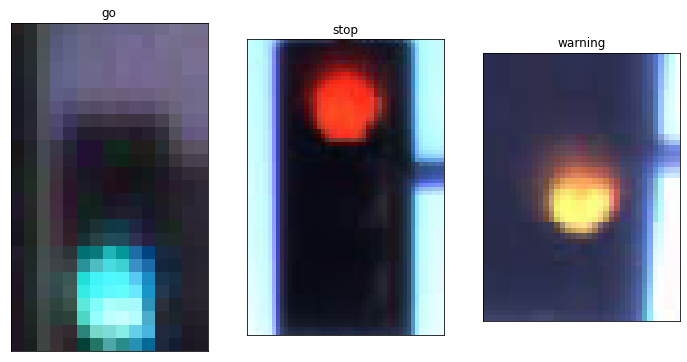

In [94]:
samples_imgs = dict()
for target in target_classes:
    index = train_annotation_df[train_annotation_df['target'] == target].index[0]
    img = img_values[index]
    samples_imgs[target] = img

_, axs = plt.subplots(1, len(target_classes), figsize=(12, 12))
axs = axs.flatten()
for target, ax in zip(samples_imgs, axs):
    ax.imshow(samples_imgs[target])
    ax.set_title(target)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

In [95]:
def image_binarization(img_values):
    
    binary_img_values = dict()
    for index in tqdm(img_values, total=len(img_values)):
        img = img_values[index]
        img = cv2.resize(img, (30, 50))
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        _, binary_img = cv2.threshold(gray, 0, 255, 
                                      cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        binary_img[binary_img == 0] = 1
        binary_img[binary_img == 255] = 0
        binary_img_values[index] = binary_img
    return binary_img_values

binary_img_values = image_binarization(img_values)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [96]:
samples_imgs = dict()
for target in target_classes:
    index = train_annotation_df[train_annotation_df['target'] == target].index[0]
    img = binary_img_values[index]
    samples_imgs[target] = img
    


In [97]:

from tqdm import tqdm

def calculate_canny_edges(img_values):
    canny_img_values = dict()
    for index in tqdm(img_values, total=len(img_values)):
        img = img_values[index]
        img = cv2.resize(img, (30, 50))
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, threshold1=50, threshold2=150)
        canny_img_values[index] = edges
    return canny_img_values

canny_img_values= calculate_canny_edges(img_values)

100%|██████████| 3000/3000 [00:00<00:00, 12269.13it/s]


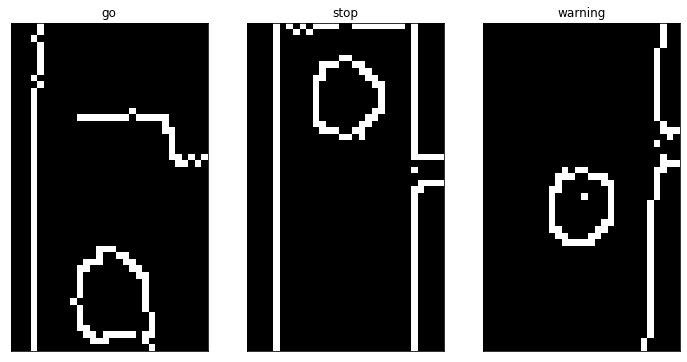

In [98]:
samples_imgs = dict()
for target in target_classes:
    index = train_annotation_df[train_annotation_df['target'] == target].index[0]
    img = canny_img_values[index]
    samples_imgs[target] = img
    
_, axs = plt.subplots(1, len(target_classes), figsize=(12, 12))
axs = axs.flatten()
for target, ax in zip(samples_imgs, axs):
    ax.imshow(samples_imgs[target], cmap='gray')
    ax.set_title(target)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

In [99]:
def image_to_vector(binary_img_values, annotation_df):
    
    binary_img_vectors = dict()
    for index in tqdm(binary_img_values, total=len(binary_img_values)):
        img = binary_img_values[index]
        img_vector = np.c_[img.ravel()].transpose()[0]
        binary_img_vectors[index] = img_vector

    img_columns = ["p"+str(i) for i in range(1,1501)]
    df_img_values = pd.DataFrame(binary_img_vectors.values(), 
                                 index=binary_img_vectors.keys(), 
                                 columns=img_columns)
    return pd.merge(annotation_df, df_img_values, left_index=True, right_index=True)

df_img_values = image_to_vector(canny_img_values, train_annotation_df)
df_img_values.head()

100%|██████████| 3000/3000 [00:00<00:00, 111112.30it/s]


filename target    x1   y1    x2   y2  \
0  dayClip5--00296.jpg     go   675  359   690  384   
1  dayClip1--01560.jpg     go   660  322   672  342   
2  dayClip2--00691.jpg     go   842  129   884  209   
3  dayClip8--01037.jpg     go  1187  268  1238  318   
4  dayClip2--00317.jpg     go  1248  337  1275  382   

                                          image_path  p1  p2   p3  ...  p1491  \
0  ./input/lisa-traffic-light-dataset/dayTrain/da...   0   0    0  ...      0   
1  ./input/lisa-traffic-light-dataset/dayTrain/da...   0   0  255  ...      0   
2  ./input/lisa-traffic-light-dataset/dayTrain/da...   0   0    0  ...      0   
3  ./input/lisa-traffic-light-dataset/dayTrain/da...   0   0    0  ...      0   
4  ./input/lisa-traffic-light-dataset/dayTrain/da...   0   0    0  ...      0   

   p1492  p1493  p1494  p1495  p1496  p1497  p1498  p1499  p1500  
0    255      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0      0  

[5 rows x 1507 columns]

In [100]:
X = df_img_values.drop(['filename', 'target', 'x1', 'y1', 'x2', 'y2', 'image_path'], axis=1)
y = df_img_values["target"]

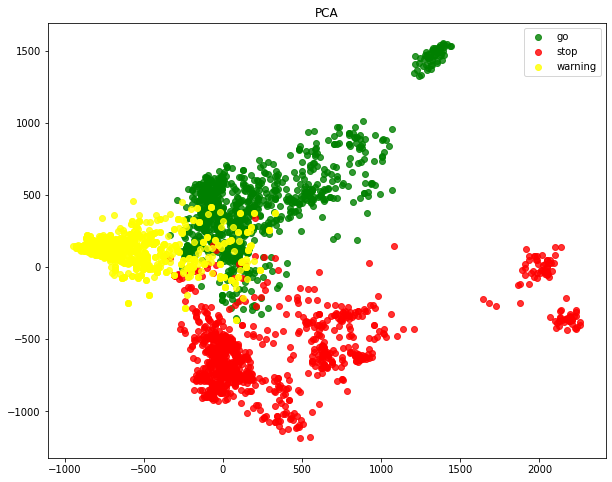

In [101]:
pca = PCA(n_components=2)
X_r = pca.fit_transform(X)
y_r = pd.Series(y.values.ravel())

plt.figure(figsize=(10,8))
for target in target_classes:
    plt.scatter(X_r[y_r == target, 0], 
                X_r[y_r == target, 1], 
                color=color_map[target], alpha=.8, label=target)
plt.legend(loc="best")
plt.title('PCA')
plt.show()

In [102]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [103]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train.values.ravel());

y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score( y_test,y_pred))

              precision    recall  f1-score   support

          go       0.95      0.91      0.93       250
        stop       0.93      0.96      0.94       250
     warning       0.94      0.95      0.94       250

    accuracy                           0.94       750
   macro avg       0.94      0.94      0.94       750
weighted avg       0.94      0.94      0.94       750

0.9386666666666666


In [104]:
lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train.values.ravel());

y_pred = lr.predict(X_test)
print(accuracy_score( y_test,y_pred))
print(classification_report(y_test, y_pred))

0.984
              precision    recall  f1-score   support

          go       0.98      0.98      0.98       250
        stop       1.00      0.97      0.98       250
     warning       0.97      1.00      0.98       250

    accuracy                           0.98       750
   macro avg       0.98      0.98      0.98       750
weighted avg       0.98      0.98      0.98       750



In [105]:
svc = SVC()
svc.fit(X_train, y_train.values.ravel());

y_pred = svc.predict(X_test)
print(accuracy_score( y_test,y_pred))
print(classification_report(y_test, y_pred))

0.9813333333333333
              precision    recall  f1-score   support

          go       0.97      0.99      0.98       250
        stop       0.98      0.97      0.97       250
     warning       1.00      0.98      0.99       250

    accuracy                           0.98       750
   macro avg       0.98      0.98      0.98       750
weighted avg       0.98      0.98      0.98       750



In [106]:

knn = KNeighborsClassifier()
knn.fit(X_train,  y_train.values.ravel())
y_pred= knn.predict(X_test)
print(accuracy_score( y_test,y_pred))
print(classification_report(y_test,y_pred))

0.9213333333333333
              precision    recall  f1-score   support

          go       0.92      0.93      0.92       250
        stop       0.88      0.96      0.92       250
     warning       0.97      0.87      0.92       250

    accuracy                           0.92       750
   macro avg       0.92      0.92      0.92       750
weighted avg       0.92      0.92      0.92       750



In [107]:
test_folder_list = ['daySequence1','daySequence2','sample-dayClip6']

n_samples_per_class = 100

test_annotation_df = get_annotarion_dataframe(test_folder_list)
test_annotation_df = resample_dataset(test_annotation_df, n_samples_per_class)
img_values = image_traffic_light_crop(test_annotation_df)
image_hog = calculate_canny_edges(img_values)
df_img_values = image_to_vector(image_hog, test_annotation_df)

X = df_img_values.drop(['filename', 'target', 'x1', 'y1', 'x2', 'y2', 'image_path'], axis=1)
y = df_img_values["target"]

y_pred = knn.predict(X)
print(classification_report(y, y_pred))
df_img_values['pred_target'] = y_pred

100%|██████████| 300/300 [00:00<00:00, 99999.30it/s]


              precision    recall  f1-score   support

          go       0.75      0.52      0.62       100
        stop       0.55      0.90      0.68       100
     warning       0.94      0.64      0.76       100

    accuracy                           0.69       300
   macro avg       0.75      0.69      0.69       300
weighted avg       0.75      0.69      0.69       300



In [108]:
test_video = ['daySequence1'
            #   ,'daySequence2'
            #   ,'sample-dayClip6'
              ]

n_samples_per_class = 100

test_annotation_df = get_annotarion_dataframe(test_folder_list)
test_annotation_df = resample_dataset(test_annotation_df, n_samples_per_class)
img_values = image_traffic_light_crop(test_annotation_df)
image_hog = calculate_canny_edges(img_values)
df_img_values = image_to_vector(image_hog, test_annotation_df)

X = df_img_values.drop(['filename', 'target', 'x1', 'y1', 'x2', 'y2', 'image_path'], axis=1)
y = df_img_values["target"]

y_pred = lr.predict(X)
print(classification_report(y, y_pred))
df_img_values['pred_target'] = y_pred

100%|██████████| 300/300 [00:00<00:00, 149975.11it/s]


              precision    recall  f1-score   support

          go       0.94      0.81      0.87       100
        stop       0.83      0.95      0.89       100
     warning       1.00      1.00      1.00       100

    accuracy                           0.92       300
   macro avg       0.93      0.92      0.92       300
weighted avg       0.93      0.92      0.92       300



In [109]:
def show_image_with_label(df_sample, img_list):
    n_imgs = len(img_list)
    _, axs = plt.subplots(n_imgs, 1, figsize=(20*n_imgs, 16*n_imgs))
#     axs = axs.flatten()
    for filename, ax in zip(img_list, axs):
        df = df_sample[df_sample['filename'] == filename].copy()
        image_path = df['image_path'].values[0]
        img = cv2.imread(image_path + filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for _, row in df.iterrows():
            target = row['pred_target']
            x1, x2, y1, y2 = row['x1'], row['x2'], row['y1'], row['y2']
            start_point = (x1, y1)
            end_point = (x2, y2)
            color = rgb_color_map[target]
            thickness = 2
            img = cv2.rectangle(img, start_point, end_point, color, thickness)
            img = cv2.putText(img, target, (x1, y1-10), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        ax.imshow(img)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    plt.show()
    
sample_img_list = df_img_values['filename'].sample(5).values


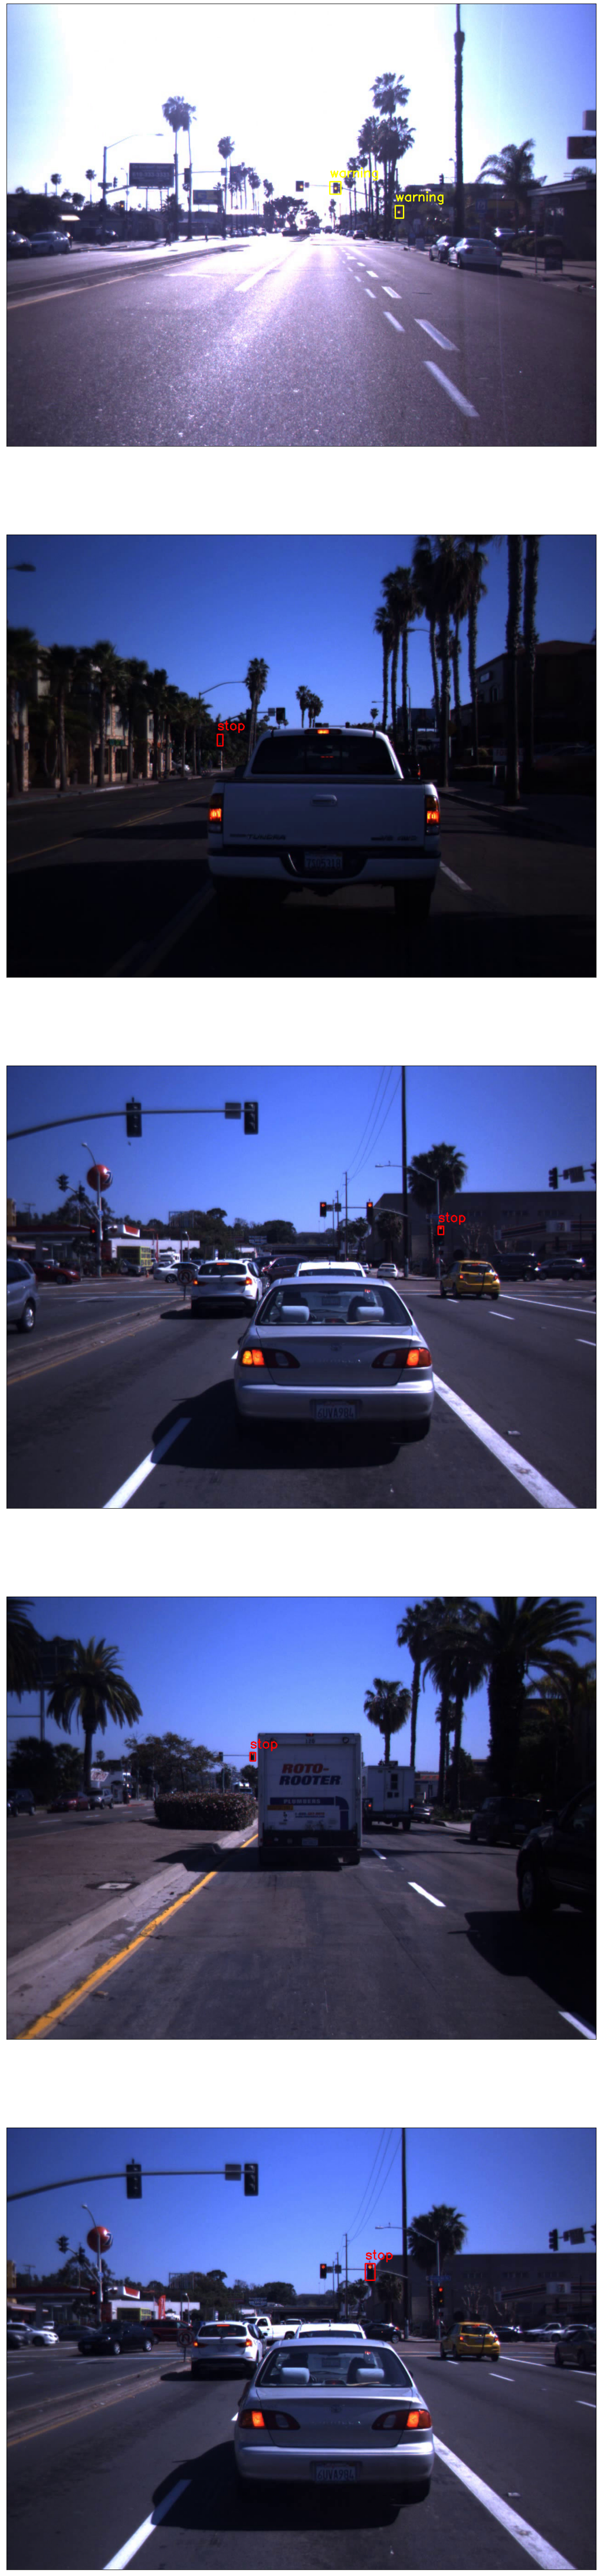

In [111]:
show_image_with_label(df_img_values, sample_img_list)

In [112]:
from sklearn.tree import DecisionTreeClassifier
import joblib

# Prepare your training data and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Preprocess your data as needed

# Create and train the decision tree model
model = DecisionTreeClassifier()
model.fit(X_train, y_train.values.ravel());

# Save the model as a pickle file
joblib.dump(model, 'decision_tree_model.pkl')

['decision_tree_model.pkl']

In [113]:
# Create a video capture object

cap = cv2.VideoCapture("C:\\Users\\u27d41\\Desktop\\TLR\\tl-detector\\TrafficLightClassification\\input\\lisa-traffic-light-dataset\\project.mp4")

n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

_, axs = plt.subplots(n_frames, 1, figsize=(20*n_frames, 16*n_frames))

for frame_idx, ax in enumerate(axs):
    ret, frame = cap.read()
    
    if ret:
        df = df_img_values[df_img_values['frame_idx'] == frame_idx].copy()

        for _, row in df.iterrows():
            target = row['pred_target']
            x1, x2, y1, y2 = row['x1'], row['x2'], row['y1'], row['y2']
            start_point = (x1, y1)
            end_point = (x2, y2)
            color = rgb_color_map[target]
            thickness = 2
            frame = cv2.rectangle(frame, start_point, end_point, color, thickness)
            frame = cv2.putText(frame, target, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        ax.imshow(frame)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    else:
        break

cap.release()
plt.show()

KeyError: 'frame_idx'

ValueError: Image size of 3111840x2489472 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 3.11184e+06x2.48947e+06 with 2161 Axes>

In [ ]:


cap = cv2.VideoCapture("C:\\Users\\u27d41\\Desktop\\TLR\\tl-detector\\TrafficLightClassification\\input\\lisa-traffic-light-dataset\\project.mp4")

while True:
    ret, frame = cap.read()
    
    if not ret:
        break
    
    cv2.imshow("Video", frame)
    
    # Break the loop if 'q' is pressed on the keyboard
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


error: OpenCV(4.7.0) C:\Users\u27d41\AppData\Local\Temp\pip-install-ivh46im6\opencv-python-headless_1960f67621e043c4b5638dac1353d421\opencv\modules\highgui\src\window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [ ]:
cap = cv2.VideoCapture("C:\\Users\\u27d41\\Desktop\\TLR\\tl-detector\\TrafficLightClassification\\input\\lisa-traffic-light-dataset\\project.mp4")
# Define the Sobel filters in x and y directions
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

# Define the duration for video recording in seconds
record_duration = 15

# Define the codec for saving the video file
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# Get the dimensions of the frames
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create a video writer object to save the output video
out = cv2.VideoWriter('output_video.mp4', fourcc, 20.0, (2*width, height))


while(cap.isOpened()):
    # Capture a frame from the webcam
    ret, frame = cap.read()
    
    if ret:
        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)    

        # Apply Gaussian Blur to reduce noise
        gray_frame = cv2.GaussianBlur(gray, (3, 3), 0)

        # Apply the Sobel filters to the grayscale image
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

        # Obtain the gradient magnitude and orientation
        grad_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)

        # Normalize gradient magnitude to 0-255 range
        grad_mag_norm = cv2.normalize(grad_mag, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

        # Threshold the image to obtain binary edge map
        threshold_value = 25
        _, threshold_edge_map = cv2.threshold(grad_mag_norm, threshold_value, 255, cv2.THRESH_BINARY)

        # Concatenate the input frame and the gradient magnitude image side by side
        output_frame = np.concatenate((frame, cv2.cvtColor(grad_mag_norm, cv2.COLOR_GRAY2BGR)), axis=1)

        # Write the output frame to the video writer object
        out.write(output_frame)
        
        # Display the resulting frame
        cv2.imshow('Input', frame)
        cv2.imshow('Gradient Magnitude', grad_mag_norm)


        # Display the frame rate on the input frame
        cv2.putText(frame, 'FPS: {:.2f}'.format(fps), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Break the loop if 'q' is pressed on the keyboard
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# Release the video capture and video writer objects
cap.release()
out.release()

# Close all windows
cv2.destroyAllWindows()


error: OpenCV(4.7.0) C:\Users\u27d41\AppData\Local\Temp\pip-install-ivh46im6\opencv-python-headless_1960f67621e043c4b5638dac1353d421\opencv\modules\highgui\src\window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'
